In [10]:
!pip install lime
!pip install shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import seaborn as sns

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_data(annotation_file, physiological_file):
    # Read annotation data
    annotation_data = pd.read_csv(annotation_file)

    # Classify emotion based on valence and arousal
    def classify_emotion(arousal, valence):
        arousal_bins = [-26225, -13112, 0, 13112, 26225]
        valence_bins = [-26225, -13112, 0, 13112, 26225]

        arousal_label = pd.cut([arousal], bins=arousal_bins,
                               labels=False, include_lowest=True)
        valence_label = pd.cut([valence], bins=valence_bins,
                               labels=False, include_lowest=True)

        return f'Partition_{arousal_label}_{valence_label}'
    
    annotation_data = annotation_data[annotation_data['video'].isin([1.0, 2.0])]

    annotation_data['Emotion_Partition'] = annotation_data.apply(
        lambda row: classify_emotion(row['arousal'], row['valence']), axis=1)

    # Define the rectangular partition
    rectangular_partition = {
        'arousal': (-3000, 3000), 'valence': (-3000, 3000)}
    
    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data['Emotion'] = ''

    for index, row in annotation_data.iterrows():
        arousal = row['arousal']
        valence = row['valence']

        if -3000 <= arousal <= 3000 and -3000 <= valence <= 3000:
            annotation_data.loc[index, 'Emotion'] = 'Neutral'
        else:
            if -26225 <= arousal <= -13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Anxious or Dejected'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tired or Bored'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index, 'Emotion'] = 'Polite or Sleepy'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Relaxed or Calm'
            elif -13112 <= arousal <= 0:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index, 'Emotion'] = 'Miserable or Sad'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Worried or Apathetic'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Confident or Attentive'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Pleased or Glad'
            elif 0 <= arousal <= 13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Discontented'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Impatient'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Passionate or Amused'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Delighted or Happy'
            else:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Distressed or Defiant'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tensed or Annoyed'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Aroused or Astonished'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Excited or Adventurous'
                    
    # Scatter plot with color-coded partitions
    c = annotation_data['Emotion_Partition'].astype('category').cat.codes
    plt.scatter(annotation_data['valence'], annotation_data['arousal'],
                c=c, cmap='viridis', label='Other Partitions')

    # Draw vertical lines for Arousal partitions
    arousal_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in arousal_bins[1:-1]:
        plt.axvline(x=bin_value, color='black', linestyle='--', linewidth=1)

    # Draw horizontal lines for Valence partitions
    valence_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in valence_bins[1:-1]:
        plt.axhline(y=bin_value, color='black', linestyle='--', linewidth=1)

    # Create a mask for points inside the rectangular partition
    mask = (
        (annotation_data['arousal'] >= rectangular_partition['arousal'][0]) &
        (annotation_data['arousal'] <= rectangular_partition['arousal'][1]) &
        (annotation_data['valence'] >= rectangular_partition['valence'][0]) &
        (annotation_data['valence'] <= rectangular_partition['valence'][1])
    )

    # Scatter plot for points inside the rectangular partition with a different color
    plt.scatter(annotation_data.loc[mask,
                'valence'], annotation_data.loc[mask, 'arousal'], c='red', label='Rectangular Partition')

    plt.title(
        'Emotion Partitions based on Arousal and Valence with Extra Partition Rectangle')
    plt.xlabel('Arousal')
    plt.ylabel('Valence')
    plt.legend()
    plt.show()

    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data_1 = annotation_data.drop('Emotion_Partition', axis=1)
    physiological_data = pd.read_csv(physiological_file)
    # Assuming you have a DataFrame named 'merged_data' with columns 'video_x', 'video_y', and 'time'

    annotation_data_1['jstime'] = annotation_data_1['jstime'].astype('int')
    physiological_data['daqtime'] = physiological_data['daqtime'].astype('int')

    annotation_data_1.rename(columns={"jstime": "time"}, inplace=True)

    physiological_data.rename(columns={"daqtime": "time"}, inplace=True)

    merged_data = pd.merge(
        annotation_data_1, physiological_data, on="time", how="left")

    return merged_data

# merged_data = preprocess_data(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_annotation/sub_{subject}.csv',
#                               f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_physiological/sub_{subject}.csv')
    

In [12]:
# print(X_test[0:100])
# np.array(shap_values_RF_test).shape

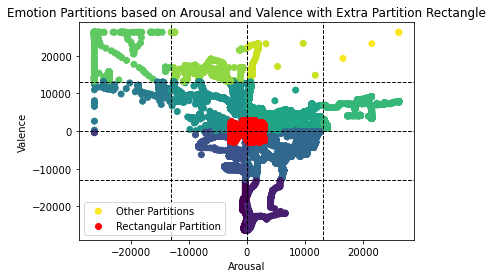

['Excited or Adventurous' 'Aroused or Astonished' 'Passionate or Amused'
 'Confident or Attentive' 'Polite or Sleepy' 'Tired or Bored'
 'Frustrated or Impatient' 'Tensed or Annoyed' 'Worried or Apathetic'
 'Frustrated or Discontented' 'Delighted or Happy' 'Distressed or Defiant'
 'Miserable or Sad']
        valence  arousal  video_x                 Emotion      ecg        bvp  \
0       26225.0  26225.0      2.0  Excited or Adventurous  1.26330  37.697818   
1       26225.0  26225.0      2.0  Excited or Adventurous  0.89204  37.397524   
2       26225.0  26225.0      2.0  Excited or Adventurous  0.80332  42.753809   
3       26225.0  26225.0      2.0  Excited or Adventurous  0.81318  37.203834   
4       26225.0  26225.0      2.0  Excited or Adventurous  0.72776  43.083112   
...         ...      ...      ...                     ...      ...        ...   
145524  19556.0   4160.0      2.0      Delighted or Happy  0.81318  35.973710   
145527  19556.0   4160.0      2.0      Delighted or

In [13]:
#FOR 20-24 AGE CATEGORY all merged

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Preprocess data for the current subject
merged_data_1 = preprocess_data(
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/amusing_annotations.csv',
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/amusing_physiological.csv'
)
    

merged_data_1['valence'] = merged_data_1['valence'].fillna(method="ffill")
merged_data_1['arousal'] = merged_data_1['arousal'].fillna(method="ffill")
merged_data_1 = merged_data_1[merged_data_1['video_x'] == merged_data_1['video_y']]
merged_data_1 = merged_data_1[merged_data_1['Emotion'] != 'Neutral']
sub_data = merged_data_1.drop('time', axis=1)
print(sub_data['Emotion'].unique())
print(sub_data)
print(len(sub_data))
label_encoder = LabelEncoder()
X=sub_data.drop(['Emotion','valence','arousal','video_y','video_x'],axis=1)
y=sub_data['Emotion']
y_encoded = label_encoder.fit_transform(sub_data['Emotion'])
encoded_classes = label_encoder.classes_
y = y_encoded

print(len(X))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)





TIME to interpret

 69.85712623596191 seconds


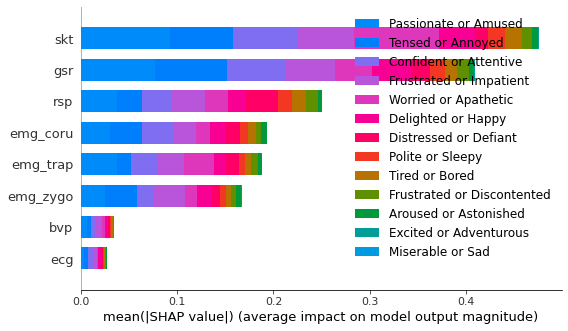

In [14]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
t0 = time.time()
explainerRF = shap.TreeExplainer(rf)
shap_values_RF_test = explainerRF.shap_values(X_test[0:100])
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()

class_names = encoded_classes
shap.summary_plot(shap_values_RF_test, X_test,class_names=class_names)


In [15]:
y_test

array([ 5, 10, 11, ..., 12, 12,  6])

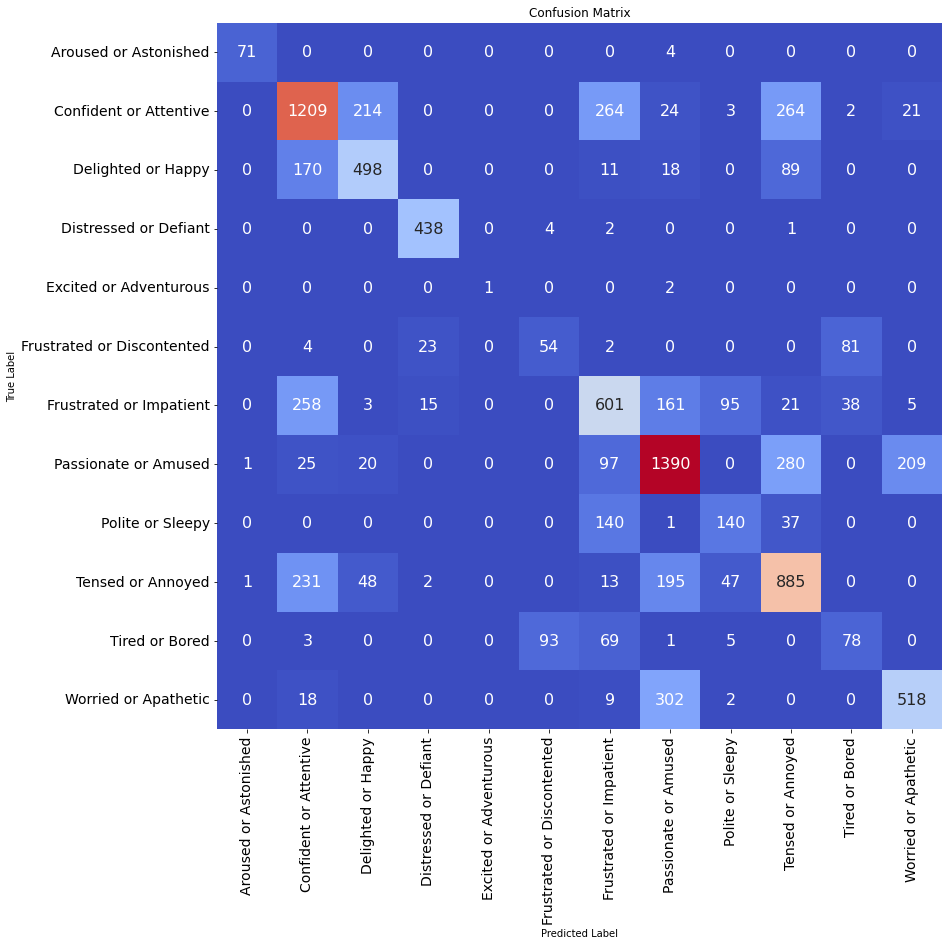

<Figure size 432x288 with 0 Axes>

In [16]:

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Extract unique labels from y_test
unique_labels = sorted(set(y_test))

# Create a filtered list of class names
filtered_class_names = [class_names[i] for i in unique_labels]

plt.figure(figsize=(13, 13))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names,
            annot_kws={"size": 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
plt.savefig("amusing_confusion_matrix.png", bbox_inches='tight', dpi=300)


0.6172489770223482


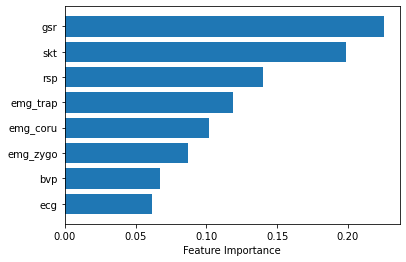

In [17]:
print(accuracy_score(y_test,y_pred))
feature_importances = rf.feature_importances_

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plotting the feature importances
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

In [19]:
for i in range(1000):
    if y_test[i]==8:
        print(X_test.iloc[i])
        print(y_test[i])
        print(i)

ecg          0.786900
bvp         37.281310
gsr         21.711960
rsp         32.159443
skt         26.171128
emg_zygo     8.602250
emg_coru     6.302500
emg_trap     7.329250
Name: 73639, dtype: float64
8
4
ecg          0.800040
bvp         36.632375
gsr         11.059176
rsp         34.550244
skt         20.022039
emg_zygo     5.111500
emg_coru     6.877500
emg_trap     6.590000
Name: 14853, dtype: float64
8
10
ecg          1.095740
bvp         36.651714
gsr         10.739832
rsp         36.408734
skt         20.313024
emg_zygo     5.768500
emg_coru     7.657750
emg_trap     6.138250
Name: 75017, dtype: float64
8
11
ecg          0.941320
bvp         37.077891
gsr         12.994968
rsp         36.660395
skt         22.262204
emg_zygo     4.947250
emg_coru    10.614750
emg_trap    13.900000
Name: 60767, dtype: float64
8
23
ecg          0.819760
bvp         37.010085
gsr         30.105720
rsp         31.075378
skt         22.490083
emg_zygo     5.358000
emg_coru     7.493500
emg_trap   

ecg          0.744200
bvp         36.409557
gsr         16.263336
rsp         30.959182
skt         22.528646
emg_zygo     5.070500
emg_coru     6.672000
emg_trap    10.368250
Name: 120685, dtype: float64
8
298
ecg          0.777040
bvp         37.116629
gsr         11.000040
rsp         34.811627
skt         20.018539
emg_zygo     5.070500
emg_coru     6.507750
emg_trap     6.549000
Name: 15337, dtype: float64
8
299
ecg          1.085880
bvp         37.949645
gsr         17.118888
rsp         30.707522
skt         26.041418
emg_zygo     4.947250
emg_coru     7.616750
emg_trap     6.631000
Name: 34251, dtype: float64
8
301
ecg          0.780340
bvp         36.554839
gsr         11.067048
rsp         34.830953
skt         20.018539
emg_zygo     4.947250
emg_coru     6.631000
emg_trap     6.220250
Name: 15289, dtype: float64
8
302
ecg          0.780340
bvp         36.671113
gsr         16.909920
rsp         30.813996
skt         26.027397
emg_zygo     4.865000
emg_coru     7.575500
emg_t

ecg          0.780340
bvp         35.518464
gsr         16.976952
rsp         31.985208
skt         26.027397
emg_zygo     4.865000
emg_coru     7.206000
emg_trap    11.805500
Name: 34803, dtype: float64
8
600
ecg          0.777040
bvp         36.274003
gsr         11.153784
rsp         34.637391
skt         20.022039
emg_zygo     5.029500
emg_coru     6.590000
emg_trap     7.616750
Name: 14469, dtype: float64
8
601
ecg          0.780340
bvp         36.293343
gsr         10.247016
rsp         36.399071
skt         20.246419
emg_zygo     7.698750
emg_coru     6.466750
emg_trap     5.809750
Name: 34100, dtype: float64
8
602
ecg          0.809900
bvp         36.303013
gsr         10.731936
rsp         36.292597
skt         20.306003
emg_zygo     5.768500
emg_coru     7.740000
emg_trap     6.138250
Name: 75665, dtype: float64
8
622
ecg          0.987320
bvp         34.772654
gsr         34.154760
rsp         43.474722
skt         33.168629
emg_zygo     5.440000
emg_coru     5.111500
emg_tr

ecg          0.941320
bvp         37.494399
gsr         13.038336
rsp         35.343996
skt         22.265725
emg_zygo     4.906250
emg_coru     9.464750
emg_trap    13.982250
Name: 60815, dtype: float64
8
777
ecg          1.020180
bvp         35.566931
gsr         16.271232
rsp         31.907783
skt         22.514625
emg_zygo     5.399000
emg_coru     6.549000
emg_trap     6.015000
Name: 120401, dtype: float64
8
783
ecg          0.829620
bvp         35.809029
gsr         34.619976
rsp         42.497130
skt         33.196671
emg_zygo     5.440000
emg_coru     5.152500
emg_trap    10.368250
Name: 61219, dtype: float64
8
785
ecg          0.363080
bvp         35.964040
gsr          7.952448
rsp         31.152803
skt         22.472562
emg_zygo    15.378500
emg_coru     9.505750
emg_trap    11.805500
Name: 139032, dtype: float64
8
791
ecg          0.777040
bvp         35.789690
gsr         10.747704
rsp         36.098976
skt         20.320024
emg_zygo     5.809750
emg_coru     7.740000
emg_

In [20]:
instance_index = 4
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])
for i in range(len(class_names)):
    print(class_names[i])
    print(shap_values_RF_test[i][instance_index][:])

ecg          0.786900
bvp         37.281310
gsr         21.711960
rsp         32.159443
skt         26.171128
emg_zygo     8.602250
emg_coru     6.302500
emg_trap     7.329250
Name: 73639, dtype: float64
Passionate or Amused
Aroused or Astonished
[-6.81412972e-04  1.95223412e-05 -7.23997931e-03  2.97013304e-03
 -6.47333656e-03  4.63461022e-03  7.77094528e-03 -8.23128759e-03]
Confident or Attentive
[ 0.00148026 -0.00046527 -0.05381881 -0.01139802 -0.15093073 -0.021941
  0.01863835  0.0098139 ]
Delighted or Happy
[-0.00074611 -0.00118521 -0.06062353  0.01604752 -0.05147688 -0.00150519
  0.01892909 -0.00168846]
Distressed or Defiant
[-0.00080641 -0.00023415 -0.01677021 -0.01423274 -0.00416784  0.00130457
 -0.02457416  0.01023036]
Excited or Adventurous
[ 1.37708570e-05  1.91304808e-05  5.26285734e-05 -2.49330611e-04
  5.20547082e-05  1.34512730e-04 -2.08881326e-04  4.85917697e-06]
Frustrated or Discontented
[-0.00024172 -0.00063213  0.00742521 -0.00826189 -0.00968565 -0.00311153
  0.00025

In [21]:
colour_scheme = 'cool'

FOR  Aroused or Astonished


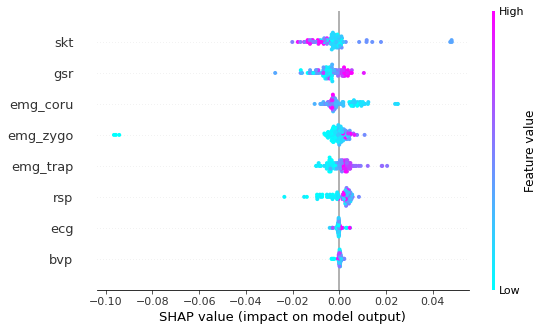

<Figure size 432x288 with 0 Axes>

FOR  Confident or Attentive


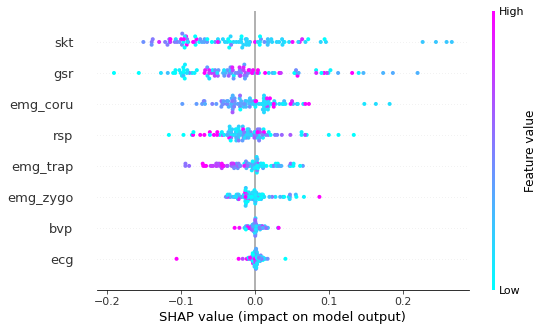

<Figure size 432x288 with 0 Axes>

FOR  Delighted or Happy


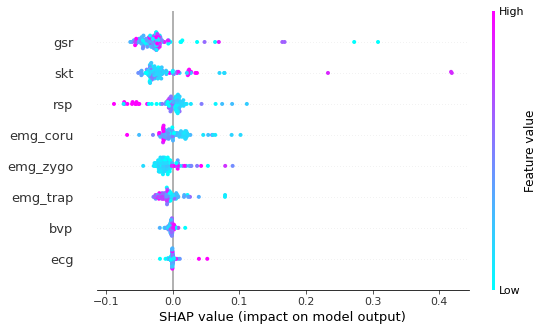

<Figure size 432x288 with 0 Axes>

FOR  Distressed or Defiant


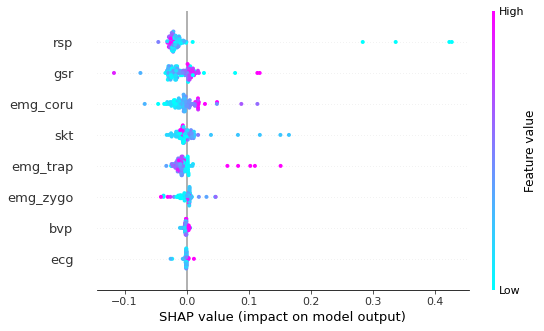

<Figure size 432x288 with 0 Axes>

FOR  Excited or Adventurous


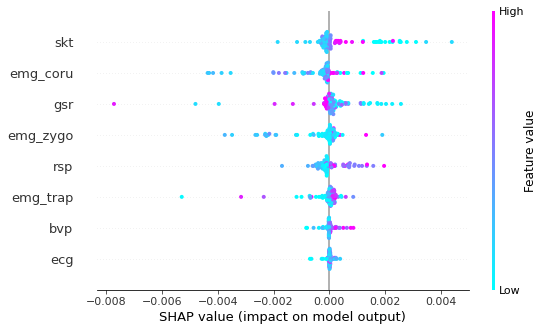

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Discontented


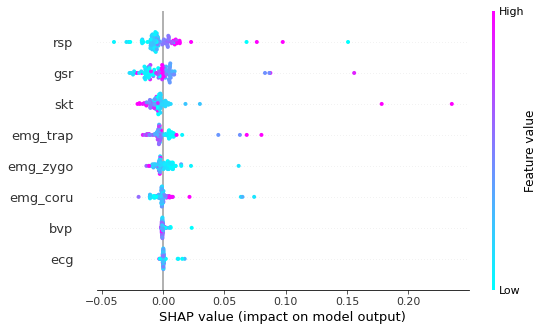

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Impatient


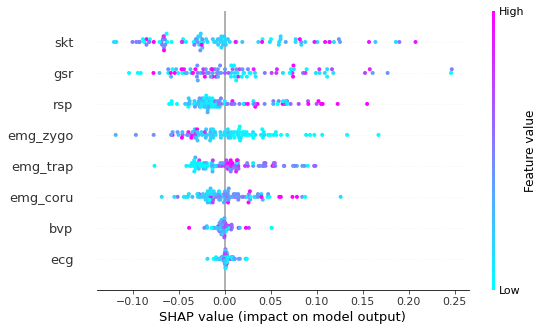

<Figure size 432x288 with 0 Axes>

FOR  Miserable or Sad


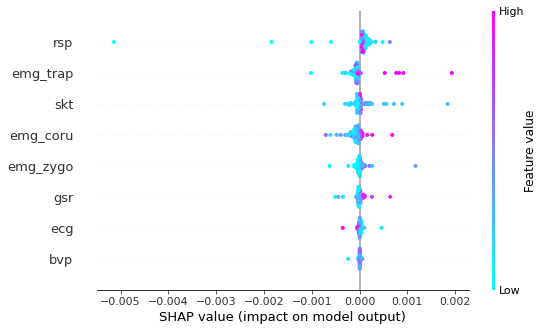

<Figure size 432x288 with 0 Axes>

FOR  Passionate or Amused


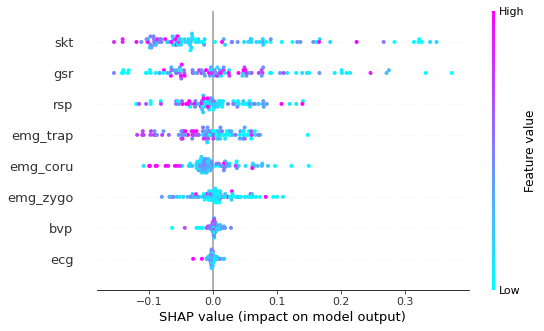

<Figure size 432x288 with 0 Axes>

FOR  Polite or Sleepy


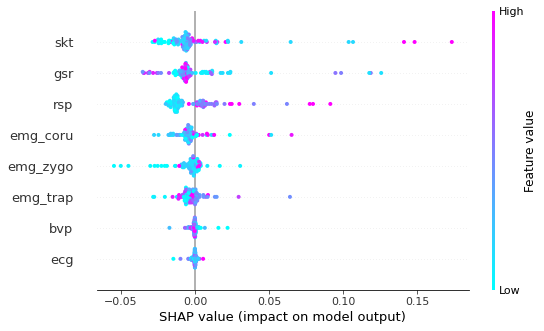

<Figure size 432x288 with 0 Axes>

FOR  Tensed or Annoyed


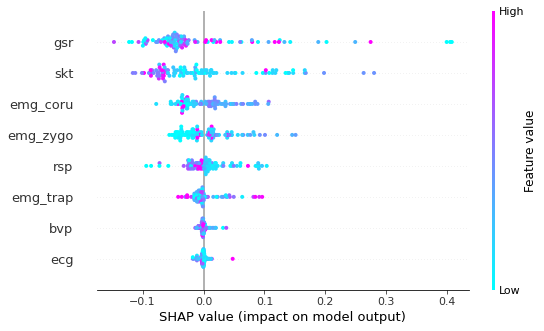

<Figure size 432x288 with 0 Axes>

FOR  Tired or Bored


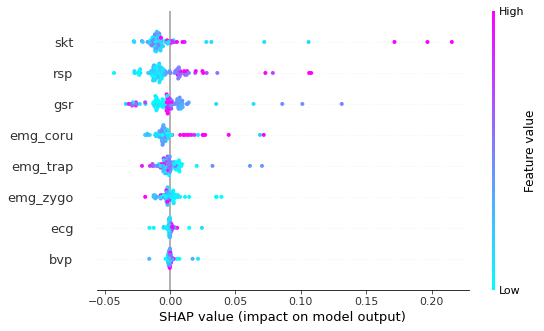

<Figure size 432x288 with 0 Axes>

FOR  Worried or Apathetic


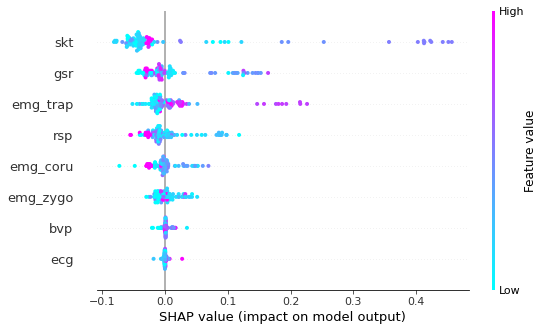

<Figure size 432x288 with 0 Axes>

In [22]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,cmap=colour_scheme)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png', bbox_inches='tight')
    plt.show()

FOR  Aroused or Astonished


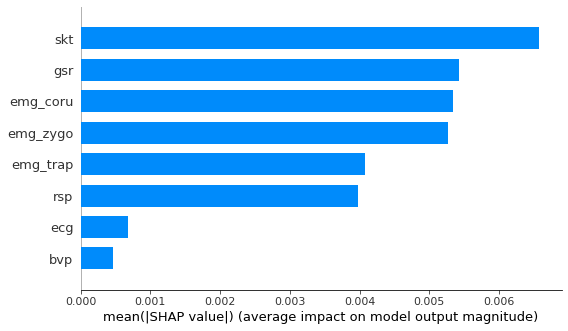

FOR  Confident or Attentive


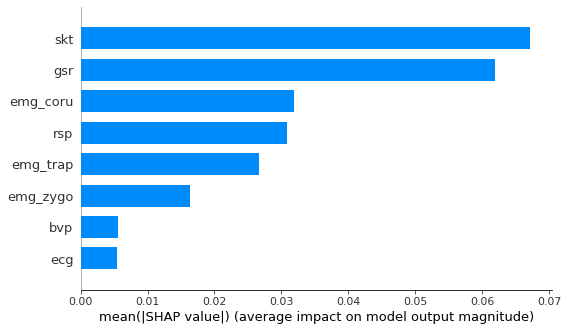

FOR  Delighted or Happy


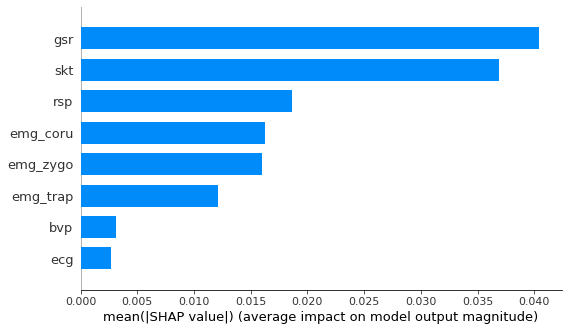

FOR  Distressed or Defiant


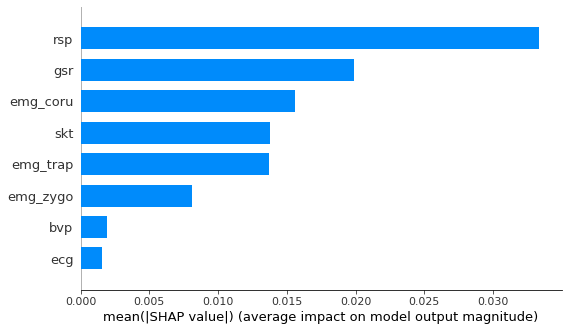

FOR  Excited or Adventurous


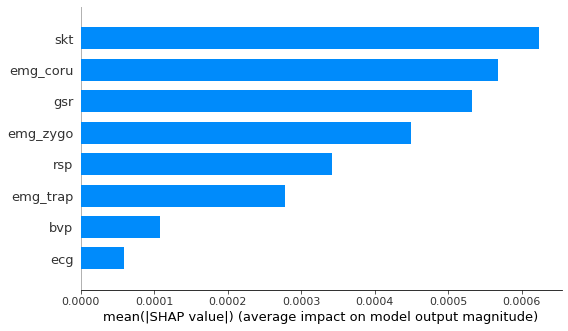

FOR  Frustrated or Discontented


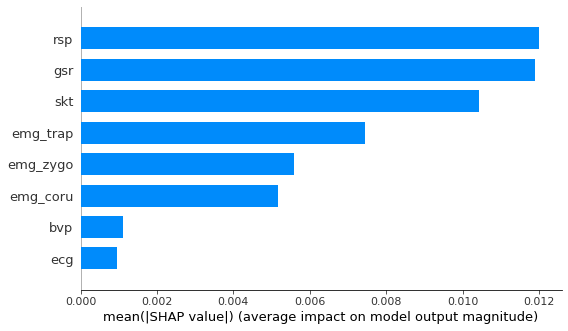

FOR  Frustrated or Impatient


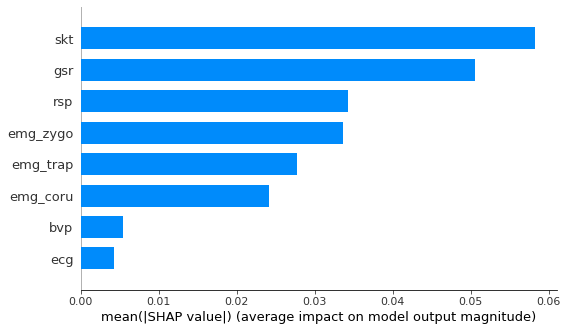

FOR  Miserable or Sad


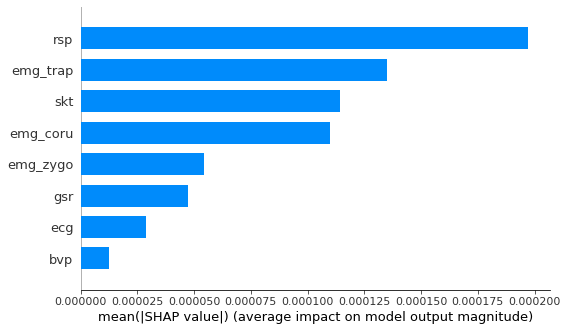

FOR  Passionate or Amused


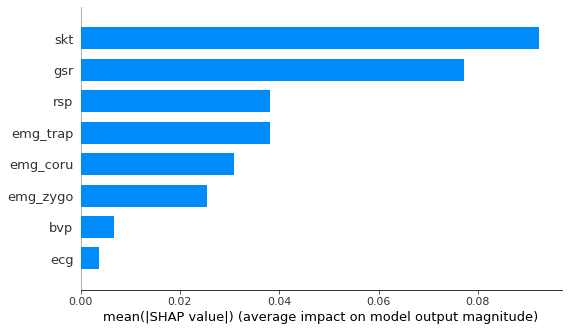

FOR  Polite or Sleepy


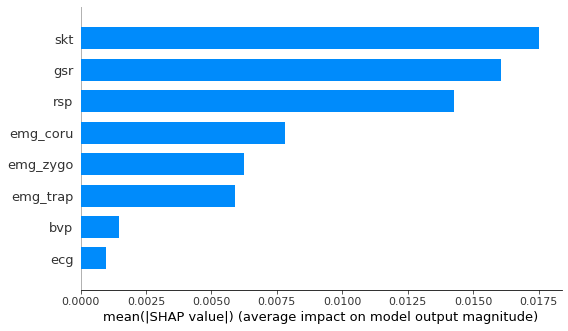

FOR  Tensed or Annoyed


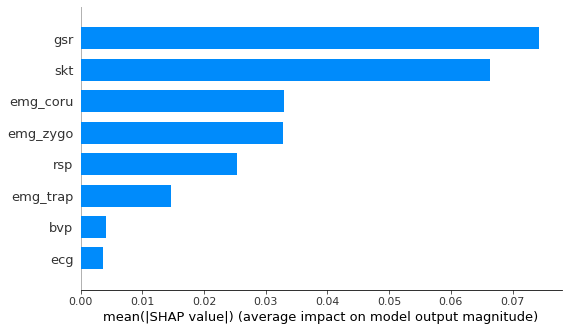

FOR  Tired or Bored


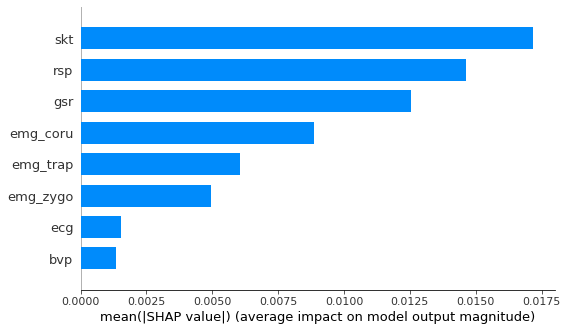

FOR  Worried or Apathetic


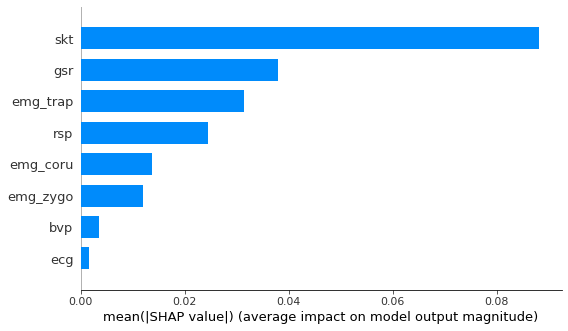

<Figure size 432x288 with 0 Axes>

In [23]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,plot_type="bar")

plt.tight_layout()

# Save or show the plot
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.show()

In [46]:
shap.initjs()
instance_index = 45
from IPython.display import display
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])

for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index][:], X_test.iloc[[instance_index]], plot_cmap="GnPR"))
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][:][:], X_test.iloc[0:100],plot_cmap="GnPR"))

ecg          0.763900
bvp         35.857496
gsr          7.960344
rsp         31.152803
skt         22.476062
emg_zygo    17.021250
emg_coru    15.666000
emg_trap    10.163000
Name: 139040, dtype: float64
Passionate or Amused
CLASS  Aroused or Astonished


CLASS  Aroused or Astonished


CLASS  Confident or Attentive


CLASS  Confident or Attentive


CLASS  Delighted or Happy


CLASS  Delighted or Happy


CLASS  Distressed or Defiant


CLASS  Distressed or Defiant


CLASS  Excited or Adventurous


CLASS  Excited or Adventurous


CLASS  Frustrated or Discontented


CLASS  Frustrated or Discontented


CLASS  Frustrated or Impatient


CLASS  Frustrated or Impatient


CLASS  Miserable or Sad


CLASS  Miserable or Sad


CLASS  Passionate or Amused


CLASS  Passionate or Amused


CLASS  Polite or Sleepy


CLASS  Polite or Sleepy


CLASS  Tensed or Annoyed


CLASS  Tensed or Annoyed


CLASS  Tired or Bored


CLASS  Tired or Bored


CLASS  Worried or Apathetic


CLASS  Worried or Apathetic


In [36]:
import time
start = time.time()
explanation = explainerRF(X_test[0:100])
end = time.time()
print(end-start)

68.04131841659546


In [37]:
# shap.plots.force(explanation[0])
np.array(explanation).shape
print(X_test)
feature_names = ['ecg','bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap']

            ecg        bvp        gsr        rsp        skt  emg_zygo  \
125027  0.81318  39.286254  33.583080  28.849090  23.359516   5.31675   
116270  0.98074  35.818758  17.442168  35.808604  26.051939   5.52225   
8344    0.70806  33.639404  21.818424  42.322895  34.476277   9.46475   
79817   0.87232  35.838097  10.483560  37.541235  20.274461   5.89175   
73639   0.78690  37.281310  21.711960  32.159443  26.171128   8.60225   
...         ...        ...        ...        ...        ...       ...   
70677   0.83618  36.031847  16.492008  34.927764  22.321809   5.93300   
115799  0.78034  37.881838  17.584104  31.733548  26.055439   6.22025   
109344  0.79348  35.150424  20.856432  31.104368  26.129065   6.09725   
52239   0.95118  36.128662  20.095512  33.214519  27.271940   5.48125   
89754   0.80990  36.855133  41.007024  31.849685  24.351637   5.07050   

        emg_coru  emg_trap  
125027   7.00075  24.20825  
116270   7.12375   9.67000  
8344     6.05600  11.06650  
79817  

In [38]:
instance_indices = []
for i in range(1000):
    if y_test[i]==8:
        print(X_test.iloc[i])
        print(y_test[i])
        print(i)
        instance_indices.append(i)

ecg          0.786900
bvp         37.281310
gsr         21.711960
rsp         32.159443
skt         26.171128
emg_zygo     8.602250
emg_coru     6.302500
emg_trap     7.329250
Name: 73639, dtype: float64
8
4
ecg          0.800040
bvp         36.632375
gsr         11.059176
rsp         34.550244
skt         20.022039
emg_zygo     5.111500
emg_coru     6.877500
emg_trap     6.590000
Name: 14853, dtype: float64
8
10
ecg          1.095740
bvp         36.651714
gsr         10.739832
rsp         36.408734
skt         20.313024
emg_zygo     5.768500
emg_coru     7.657750
emg_trap     6.138250
Name: 75017, dtype: float64
8
11
ecg          0.941320
bvp         37.077891
gsr         12.994968
rsp         36.660395
skt         22.262204
emg_zygo     4.947250
emg_coru    10.614750
emg_trap    13.900000
Name: 60767, dtype: float64
8
23
ecg          0.819760
bvp         37.010085
gsr         30.105720
rsp         31.075378
skt         22.490083
emg_zygo     5.358000
emg_coru     7.493500
emg_trap   

Name: 77035, dtype: float64
8
221
ecg          0.800040
bvp         36.080254
gsr         37.328544
rsp         31.297989
skt         22.455020
emg_zygo     5.686500
emg_coru     7.616750
emg_trap    12.668000
Name: 34210, dtype: float64
8
228
ecg          0.727760
bvp         36.893871
gsr         31.528992
rsp         32.149780
skt         25.059796
emg_zygo     4.742000
emg_coru     6.466750
emg_trap    12.462750
Name: 21728, dtype: float64
8
230
ecg          1.112160
bvp         35.847767
gsr         36.413880
rsp         31.481888
skt         22.465541
emg_zygo     5.440000
emg_coru     7.452500
emg_trap     9.300500
Name: 35146, dtype: float64
8
232
ecg          1.066160
bvp         36.370819
gsr         10.262784
rsp         37.463810
skt         20.225376
emg_zygo     9.054000
emg_coru     7.123750
emg_trap     6.138250
Name: 34601, dtype: float64
8
234
ecg          0.859180
bvp         36.922939
gsr         13.018632
rsp         37.628323
skt         22.255204
emg_zygo     4.9

ecg          0.747480
bvp         35.470057
gsr         21.483288
rsp         32.449816
skt         26.157107
emg_zygo    13.818000
emg_coru     6.343500
emg_trap     6.795250
Name: 73975, dtype: float64
8
645
ecg          0.717900
bvp         36.380548
gsr         29.664144
rsp         30.755956
skt         22.504104
emg_zygo     6.138250
emg_coru     7.657750
emg_trap    13.530500
Name: 73428, dtype: float64
8
654
ecg          0.783620
bvp         35.576601
gsr         16.953288
rsp         31.675450
skt         26.030897
emg_zygo     4.824000
emg_coru     7.657750
emg_trap    11.600250
Name: 34602, dtype: float64
8
661
ecg          0.777040
bvp         37.174766
gsr         10.247016
rsp         36.728156
skt         20.239397
emg_zygo     8.602250
emg_coru     6.466750
emg_trap     6.097250
Name: 34136, dtype: float64
8
662
ecg          0.773760
bvp         37.784964
gsr         21.550320
rsp         31.617411
skt         26.153586
emg_zygo     5.809750
emg_coru     6.425750
emg_tr

CLASS NAME  Aroused or Astonished


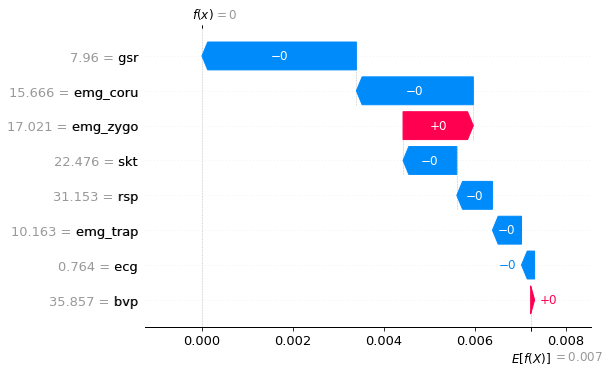

CLASS NAME  Confident or Attentive


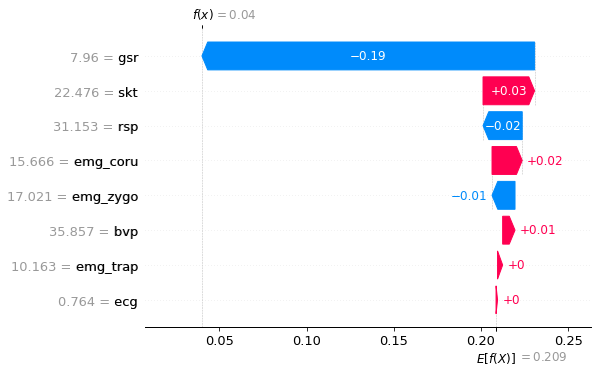

CLASS NAME  Delighted or Happy


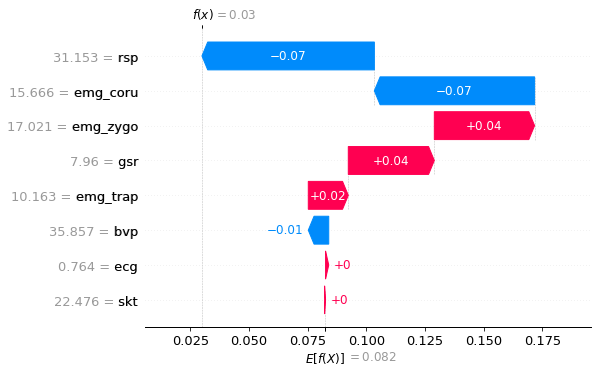

CLASS NAME  Distressed or Defiant


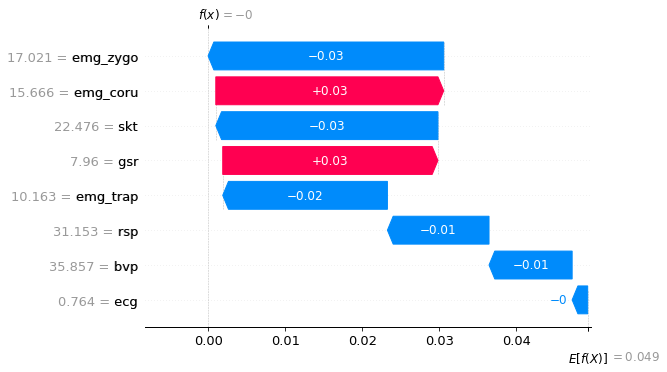

CLASS NAME  Excited or Adventurous


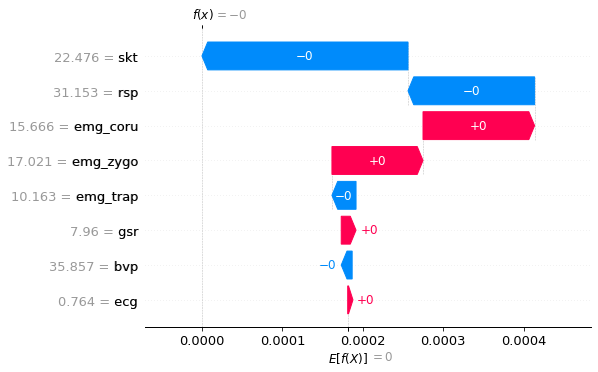

CLASS NAME  Frustrated or Discontented


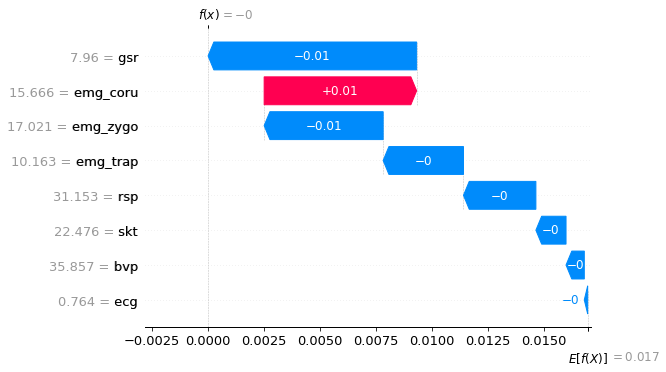

CLASS NAME  Frustrated or Impatient


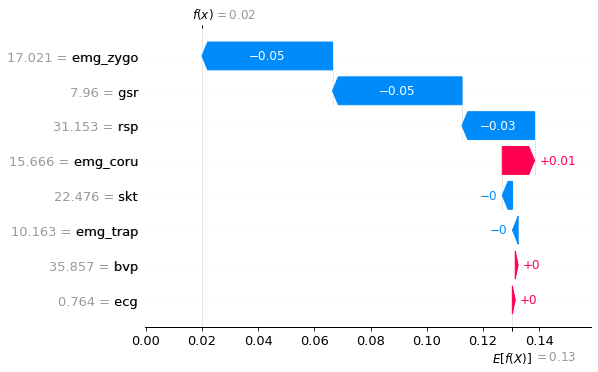

CLASS NAME  Miserable or Sad


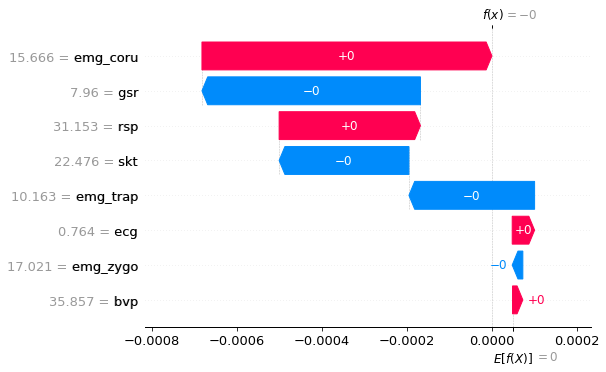

CLASS NAME  Passionate or Amused


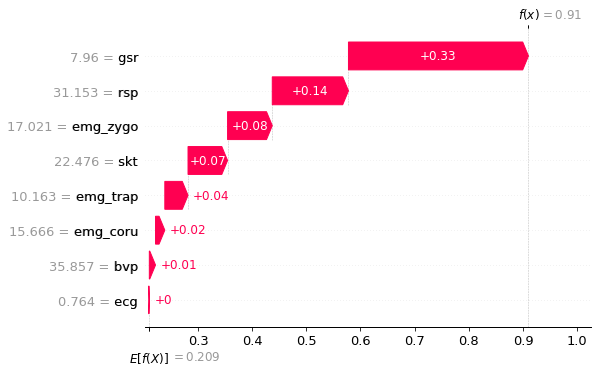

CLASS NAME  Polite or Sleepy


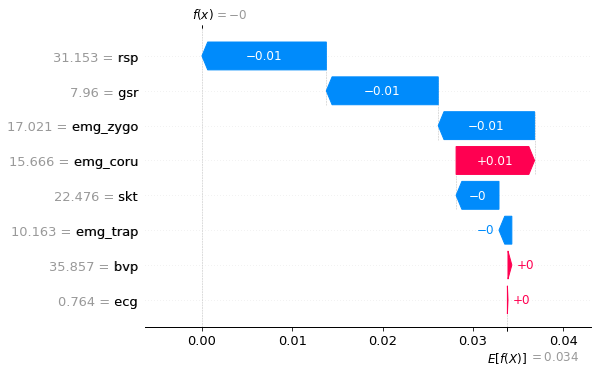

CLASS NAME  Tensed or Annoyed


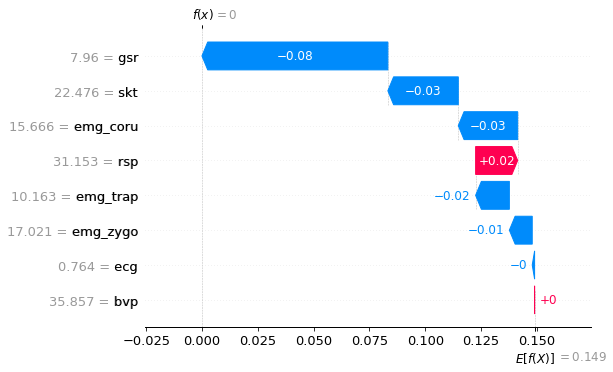

CLASS NAME  Tired or Bored


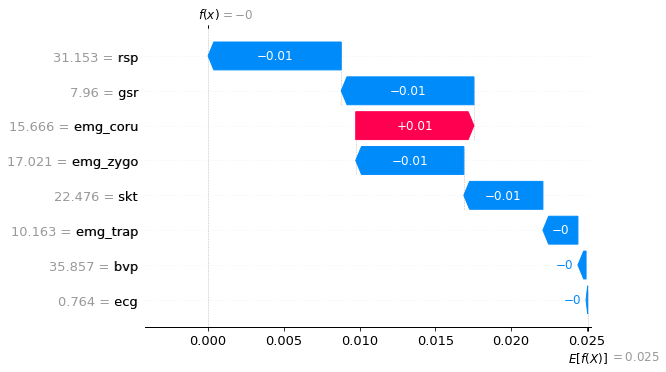

CLASS NAME  Worried or Apathetic


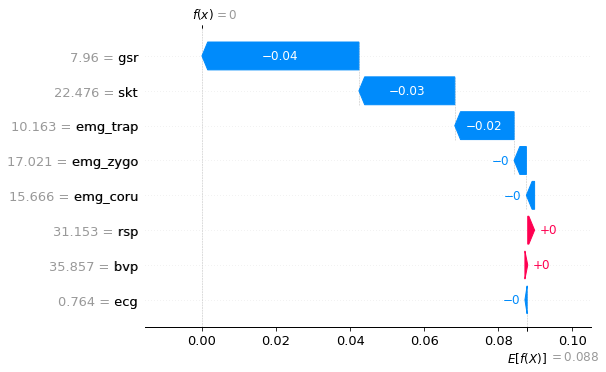

In [45]:
instance_index = 45
for i in range(len(class_names)):
    class_name = i
    print("CLASS NAME ", class_names[class_name])
    EXP = shap.Explanation(
        values=explanation[instance_index].values[:,class_name],
        base_values=explanation[instance_index].base_values[class_name],
        data = explanation[instance_index].data,
        feature_names = feature_names
    )
    shap.waterfall_plot(EXP,max_display = 8)

In [28]:
class_names[y_test[instance_index]]

'Passionate or Amused'

In [29]:
X_test.iloc[instance_index]

ecg          0.786900
bvp         37.281310
gsr         21.711960
rsp         32.159443
skt         26.171128
emg_zygo     8.602250
emg_coru     6.302500
emg_trap     7.329250
Name: 73639, dtype: float64

CLASS  Aroused or Astonished


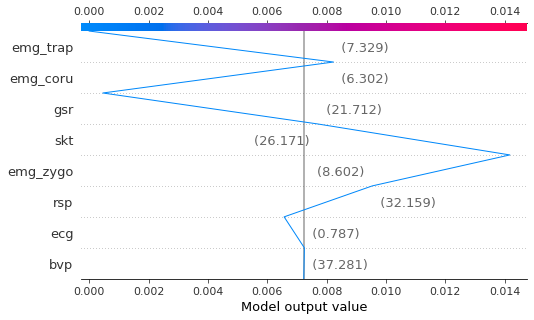

CLASS  Confident or Attentive


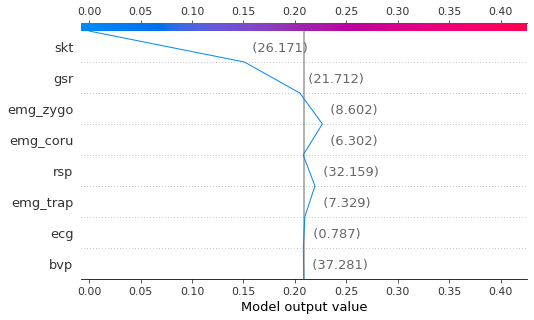

CLASS  Delighted or Happy


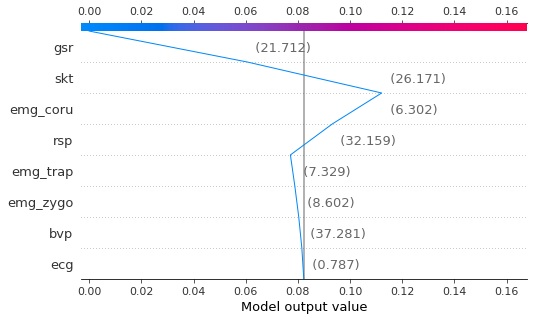

CLASS  Distressed or Defiant


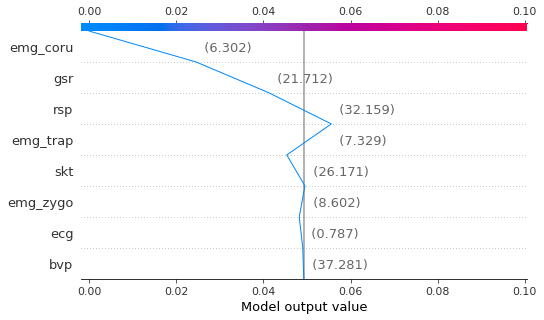

CLASS  Excited or Adventurous


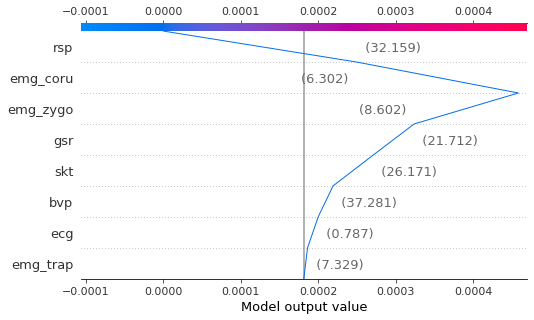

CLASS  Frustrated or Discontented


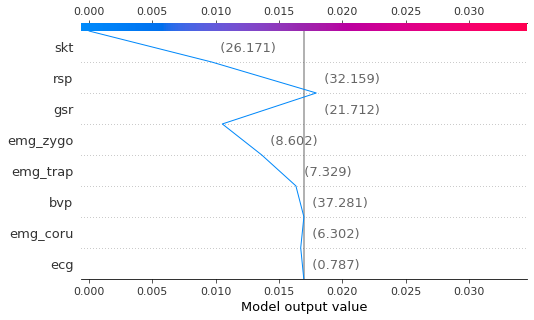

CLASS  Frustrated or Impatient


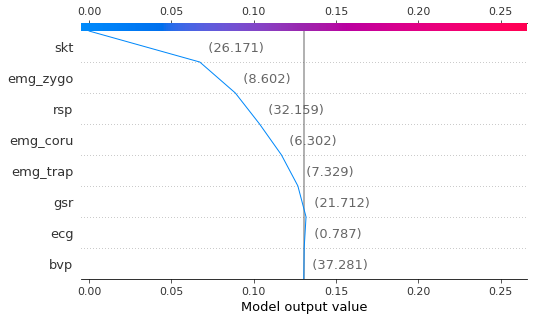

CLASS  Miserable or Sad


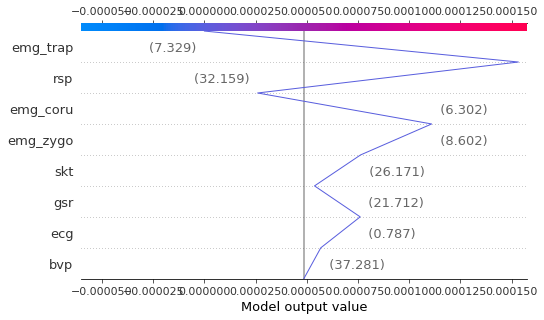

CLASS  Passionate or Amused


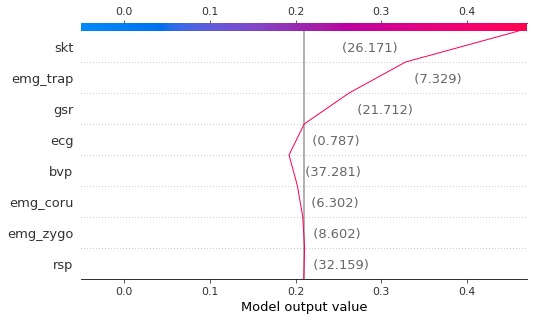

CLASS  Polite or Sleepy


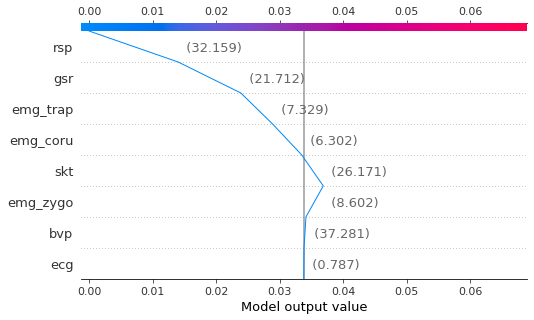

CLASS  Tensed or Annoyed


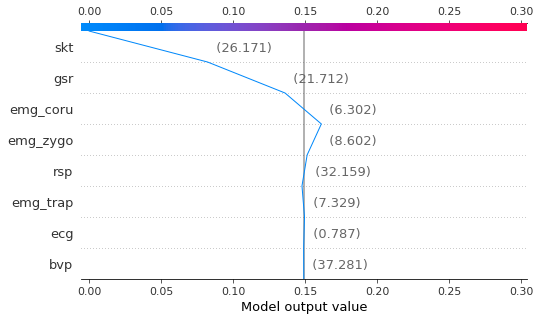

CLASS  Tired or Bored


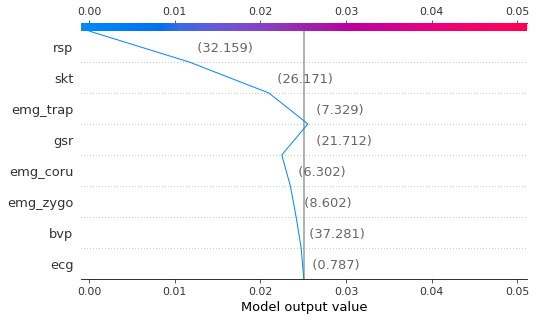

CLASS  Worried or Apathetic


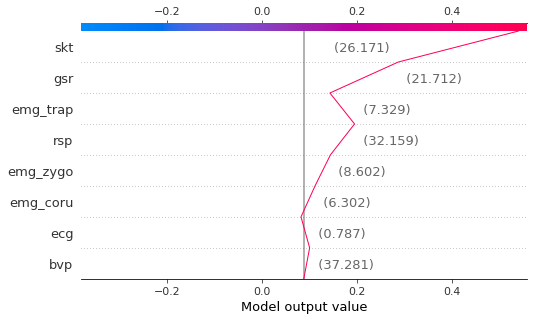

In [30]:
for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    shap.decision_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index], X_test.iloc[instance_index])

In [31]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, mode="classification",kernel_width=0.5)
t0 = time.time()

explanations_test = []

explanation_lime = explainer.explain_instance(
    X_test.values[instance_index], rf.predict_proba, num_features=10, top_labels=14)
explanations_test.append(explanation_lime)

t1 = time.time()
timeit = t1 - t0
print("TIME to interpret\n\n", timeit, "seconds")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


TIME to interpret

 7.690801620483398 seconds


In [32]:
explanation = explanations_test[0]
explanation.show_in_notebook()

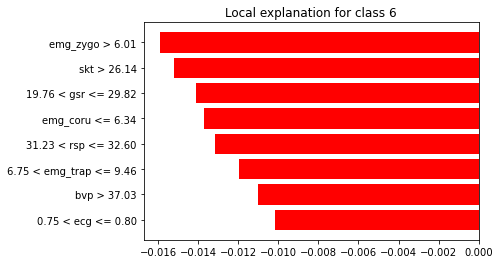

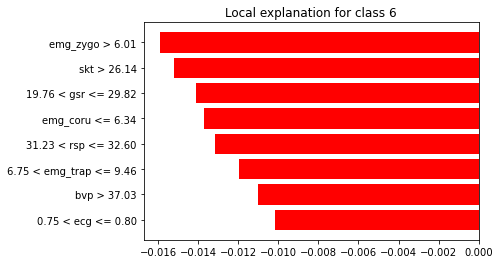

In [33]:
explanation.as_pyplot_figure(label=6)

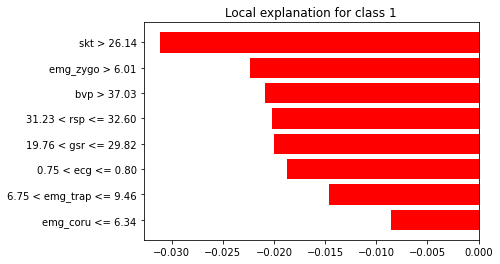

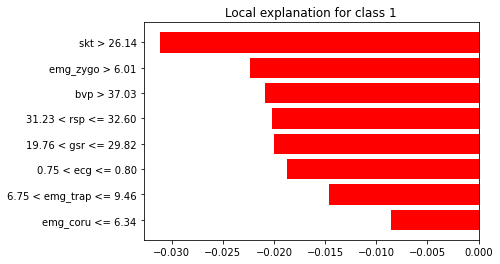

In [34]:
explanation.as_pyplot_figure(label=1)